In [1]:
import QuantLib as ql
import numpy as np
np.random.seed(42)

In [2]:
prices = {}

In [4]:
start_date = ql.Date(8, ql.February, 2016)
maturity_date = start_date + ql.Period(5, ql.Years)
schedule = ql.Schedule(start_date, maturity_date, ql.Period(ql.Semiannual), ql.TARGET(), ql.Following, ql.Following, ql.DateGeneration.Backward, False)
coupons = [0.01] * 10
bond = ql.FixedRateBond(3, 100, schedule, coupons, ql.Thirty360())

In [5]:
today = ql.Date(9, ql.May, 2018)
nodes = [today + ql.Period(i, ql.Years) for i in range(11)]
rates = [0.007, 0.010, 0.012, 0.013, 0.014, 0.016, 0.017, 0.018, 0.020, 0.021, 0.022]
discount_curve = ql.ZeroCurve(nodes, rates, ql.Actual360())

In [6]:
discount_handle = ql.RelinkableYieldTermStructureHandle(discount_curve)
bond.setPricingEngine(ql.DiscountingBondEngine(discount_handle))

In [7]:
ql.Settings.instance().evaluationDate = today

In [8]:
prices[today] = bond.cleanPrice()
print(prices[today])

99.18942082987543


In [9]:
calendar = ql.TARGET()
yesterday = calendar.advance(today, -1, ql.Days)

In [10]:
nodes = [yesterday + ql.Period(i, ql.Years) for i in range(11)]
base_rates = np.array(rates)
rates = base_rates * np.random.normal(loc=1.0, scale=0.005, size=base_rates.shape)
discount_curve = ql.ZeroCurve(nodes, list(rates), ql.Actual360())

In [11]:
ql.Settings.instance().evaluationDate = yesterday
discount_handle.linkTo(discount_curve)

In [12]:
prices[yesterday] = bond.cleanPrice()
print(prices[yesterday])

99.16663635835845


In [13]:
first_date = calendar.advance(today, -1, ql.Years)
date = calendar.advance(yesterday, -1, ql.Days)

while date >= first_date:
    nodes = [date + ql.Period(i, ql.Years) for i in range(11)]
    rates = base_rates * np.random.normal(loc=1.0, scale=0.005, size=base_rates.shape)
    discount_curve = ql.ZeroCurve(nodes, list(rates), ql.Actual360())
    ql.Settings.instance().evaluationDate = date
    discount_handle.linkTo(discount_curve)
    prices[date] = bond.cleanPrice()
    date = calendar.advance(date, -1, ql.Days)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
dates, values = zip(*sorted(prices.items()))

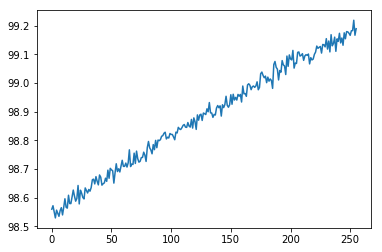

In [18]:
fig, ax = plt.subplots()
ax.plot(list(range(len(values))), values)

In [19]:
index = ql.Eonia()
tenors = [ql.Period(i, ql.Years) for i in range(1, 11)]
rates = [0.01, 0.012, 0.013, 0.014, 0.016, 0.017, 0.018, 0.02, 0.021, 0.022]
quotes = []
helpers = []
for tenor, rate in zip(tenors, rates):
    q = ql.SimpleQuote(rate)
    h = ql.OISRateHelper(2, tenor, ql.QuoteHandle(q), index)
    quotes.append(q)
    helpers.append(h)

In [20]:
risk_free_curve = ql.PiecewiseFlatForward(0, ql.TARGET(), helpers, ql.Actual360())

In [21]:
spread = ql.SimpleQuote(0.01)
discount_curve = ql.ZeroSpreadedTermStructure(ql.YieldTermStructureHandle(risk_free_curve), ql.QuoteHandle(spread))

In [22]:
prices = {}
ql.Settings.instance().evaluationDate = today
discount_handle.linkTo(discount_curve)
prices[today] = bond.cleanPrice()
print(prices[today])

96.50362161659807


In [23]:
date = calendar.advance(yesterday, -1, ql.Days)
base_rates = np.array(rates)

while date >= first_date:
    rates = base_rates * np.random.normal(loc=1.0, scale=0.005, size=base_rates.shape)
    for q, r in zip(quotes, rates):
        q.setValue(r)
    spread.setValue(spread.value()*np.random.normal(loc=1.0, scale=0.005))
    ql.Settings.instance().evaluationDate = date
    prices[date] = bond.cleanPrice()
    date = calendar.advance(date, -1, ql.Days)

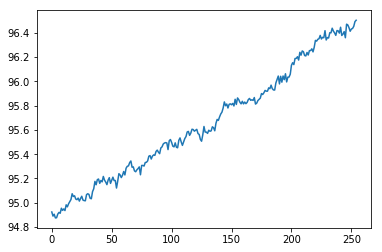

In [24]:
dates, values = zip(*sorted(prices.items()))
fig, ax = plt.subplots()
ax.plot(list(range(len(values))), values)

In [25]:
forecast_handle = ql.YieldTermStructureHandle(risk_free_curve)
index = ql.Euribor6M(forecast_handle)
bond = ql.FloatingRateBond(3, 100, schedule, index, ql.Thirty360())
bond.setPricingEngine(ql.DiscountingBondEngine(discount_handle))

In [26]:
ql.Settings.instance().evaluationDate = today
for q, r in zip(quotes, base_rates):
    q.setValue(r)
spread.setValue(0.01)

In [27]:
print(bond.cleanPrice())

RuntimeError: Missing Euribor6M Actual/360 fixing for February 6th, 2018

In [28]:
index.addFixing(ql.Date(6, ql.February, 2018), 0.005)
print(bond.cleanPrice())

97.1193932392214


In [29]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.March, 2018)
print(bond.cleanPrice())
ql.Settings.instance().evaluationDate = ql.Date(15, ql.February, 2018)
print(bond.cleanPrice())

96.84331874622792
96.79054303973298


In [30]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.February, 2018)
print(bond.cleanPrice())

RuntimeError: Missing Euribor6M Actual/360 fixing for August 4th, 2017

In [31]:
index.addFixing(ql.Date(4, ql.August, 2017), 0.004)
print(bond.cleanPrice())

96.98060241422583


In [32]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2018)
print(bond.cleanPrice())

97.2126812565699


In [33]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2019)
print(bond.cleanPrice())

RuntimeError: Missing Euribor6M Actual/360 fixing for February 6th, 2019

In [34]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2018)
future_fixing = index.fixing(ql.Date(6, ql.February, 2019))
print(future_fixing)
index.addFixing(ql.Date(6, ql.February, 2019), future_fixing)

0.011387399107860378


In [35]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2019)
print(bond.cleanPrice())

98.30830224923508


In [37]:
index.addFixing(ql.Date(3, ql.February, 2021), 0.02)
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2021)
print(index.fixing(ql.Date(3, ql.February, 2021)))

0.02


In [38]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2020)
print(index.fixing(ql.Date(3, ql.February, 2021)))

0.011367299732914539
